In [2]:
! pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 8.4 MB/s eta 0:00:0000:0100:01


In [ ]:
import h5py
import numpy as np
import os
import random
import cv2
from tqdm import tqdm

# --- Parameters ---
growth_prob = 0.7       # Probability of tumor cell growth (R1)
invasion_prob = 0.5     # Probability of invasion (R2)
death_prob = 0.3        # Probability of cell death (R3)
max_steps = 30          # Reduced iterations for 2D (vs. 3D in paper)
threshold = 10          # Max tumor state (matches paper's 0-10 range)

# MRI intensity ranges (modality-specific)
mri_ranges = {
    'flair': [0, 5000],  # FLAIR typically has higher intensity
    't1': [0, 2000],     # T1-weighted
    't1ce': [0, 2500],    # T1 contrast-enhanced
    't2': [0, 3000]       # T2-weighted
}

# --- Functions ---
def load_h5_data(h5_path):
    """Load BraTS data with flexible dimensionality handling"""
    with h5py.File(h5_path, 'r') as f:
        image = f['image'][:]          # Load MRI volume (4D: modalities x H x W x D)
        mask = f['mask'][:] if 'mask' in f else None  # Load ground truth (if exists)
        
        # Handle 3D/4D cases
        if image.ndim == 3:
            image = image[np.newaxis, ...]  # Add modality dim if missing
            if mask is not None:
                mask = mask[np.newaxis, ...]
        return {'image': image, 'mask': mask}

def quantify_tissues(slice_data):
    """Quantify brain tissues into 5 levels (simplified vs. paper's 4-level CT organs)"""
    img_norm = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min() + 1e-6) # Normalizes MRI intensities to [0, 1] for consistency across scans
    quant_map = np.zeros_like(slice_data, dtype=np.uint8)
    
    # Assign levels (refer to section 2.1 nad brats website)
    quant_map[img_norm < 0.1] = 0    # look at the assigned thresholds
    quant_map[(img_norm >= 0.1) & (img_norm < 0.3)] = 1  
    quant_map[(img_norm >= 0.3) & (img_norm < 0.6)] = 2  
    quant_map[(img_norm >= 0.6) & (img_norm < 0.8)] = 3  
    quant_map[img_norm >= 0.8] = 4    
    return quant_map

def grow_tumor_2d(quant_map): #2D implementation of Pixel2Cancer rules (vs. paper's 3D version)
    tumor_map = np.zeros_like(quant_map, dtype=np.int8)
    y, x = np.where((quant_map > 0) & (quant_map < 4))  # Start in non-necrotic tissue
    
    if len(y) == 0:
        return None
        
    idx = np.random.randint(0, len(y)) # Pick random seed location
    tumor_map[y[idx], x[idx]] = 1  # Seed tumor (matches paper's random initialization); Creates a blank map to track tumor states (0 = no tumor, 1–10 = tumor population, -1 = dead cells)
    
    for _ in range(max_steps): # Apply rules for max_steps iterations
        new_map = tumor_map.copy()
        y, x = np.where(tumor_map > 0) # Randomly places a tumor seed in viable tissue (GM/WM/edema, excluding background/necrosis).
        
        for i in range(len(y)):
            current = tumor_map[y[i], x[i]] # Get state of current tumor cell
            
            # Growth rule (R1)
            if 0 < current < threshold:
                if random.random() < ((current + 1)/11) * growth_prob:
                    new_map[y[i], x[i]] = min(current + 1, threshold) # Increase tumor state
            
            # Invasion rule (R2)
            if current > 0:
                neighbors = [(y[i]-1, x[i]), (y[i]+1, x[i]), (y[i], x[i]-1), (y[i], x[i]+1)]
                valid_neighbors = [(ny, nx) for ny, nx in neighbors if 0 <= ny < tumor_map.shape[0] and 0 <= nx < tumor_map.shape[1]] # Filter out-of-bounds neighbors
                
                if valid_neighbors:
                    ny, nx = random.choice(valid_neighbors)
                    if tumor_map[ny, nx] == 0: # Target is empty
                        tissue_type = quant_map[ny, nx]
                        invade_prob = {3: 0.3, 4: 0.1}.get(tissue_type, 1.0)  # Harder to invade 
                        if random.random() < invade_prob * invasion_prob:
                            new_map[ny, nx] = 1  # Invade neighbor
            
            # Death rule (R3)
            if current == threshold:
                if random.random() < death_prob:
                    new_map[y[i], x[i]] = -1  # Cell death due to crowding
        
        tumor_map = new_map # Update tumor map
    
    return cv2.GaussianBlur(tumor_map.astype(np.float32), (3,3), 0)  # Smooth boundaries (section 2.3 blurry boundaries)

def map_to_mri(original, tumor_map, modality): #Blend synthetic tumor into MRI based on state (0-10)
    synthetic = original.copy()
    mod_range = mri_ranges[modality] # get predefined min/max intensity values for the MRI modality 
    
    for state in range(1, threshold + 1): # For each tumor state (1 to 10), create a mask of pixels with ≥ that state
        mask = tumor_map >= state
        blend = state / threshold  # Linear interpolation
        synthetic[mask] = original[mask] * (1 - blend) + mod_range[0] * blend  # Darken tumor pixels; Higher states = more intense tumor appearance
    
    synthetic[tumor_map == -1] = mod_range[0] * 0.8  # darker regions
    noise = np.random.normal(0, 0.02 * mod_range[1], synthetic.shape)  # Add noise
    return np.clip(synthetic + noise, mod_range[0], mod_range[1])  # Clip to valid range; Ensures values stay within the valid range for the modality

def save_h5(data, output_path): #Save in BraTS HDF5 format
    with h5py.File(output_path, 'w') as f:
        f.create_dataset('image', data=data['image'])
        if 'mask' in data:
            f.create_dataset('mask', data=data['mask'])


# --- Import data ---
input_dir = "/Users/jiexili/Downloads/archive 2/BraTS2020_training_data/content/data/"
output_dir = "/Users/jiexili/Downloads/synthetic_tumors"
os.makedirs(output_dir, exist_ok=True)

h5_files = [f for f in os.listdir(input_dir) if f.endswith('.h5')]

for h5_file in tqdm(h5_files):
    try:
        data = load_h5_data(os.path.join(input_dir, h5_file))
        image = data['image'] # Extract MRI volume
        mask = data['mask'] 
        
        # Initialize output volume
        synthetic_volume = np.zeros_like(image)  # Initialize synthetic MRI volume
        tumor_mask = np.zeros(image.shape[1:], dtype=np.uint8)  # initializen3D mask
        
        # Process each slice
        for z in range(image.shape[-1]):
            # Process FLAIR (modality 0) first
            flair_slice = image[0, :, :, z] if image.ndim == 4 else image[:, :, z]
            
            result = grow_tumor_2d(quantify_tissues(flair_slice))
            if result is None:
                continue # Skip if no tumor created
                
            slice_tumor_map = result
            
            # Apply to all modalities
            if image.ndim == 4:
                for mod in range(image.shape[0]):
                    modality = ['flair', 't1', 't1ce', 't2'][mod]
                    original_slice = image[mod, :, :, z]
                    synthetic_volume[mod, :, :, z] = map_to_mri(
                        original_slice,
                        slice_tumor_map,
                        modality
                    )
            else:
                synthetic_volume[:, :, z] = map_to_mri(
                    image[:, :, z],
                    slice_tumor_map,
                    'flair'
                )
            
            tumor_mask[:, :, z] = (slice_tumor_map > 0).astype(np.uint8) # Binary mask from tumor map
        
        # Save results
        save_h5(
            {'image': synthetic_volume,
             'mask': tumor_mask[np.newaxis, ...]  # Add channel dim
            },
            os.path.join(output_dir, f"synthetic_{h5_file}"))
            
    except Exception as e:
        print(f"Error processing {h5_file}: {str(e)}")

100%|██████████| 57195/57195 [2:38:07<00:00,  6.03it/s]      


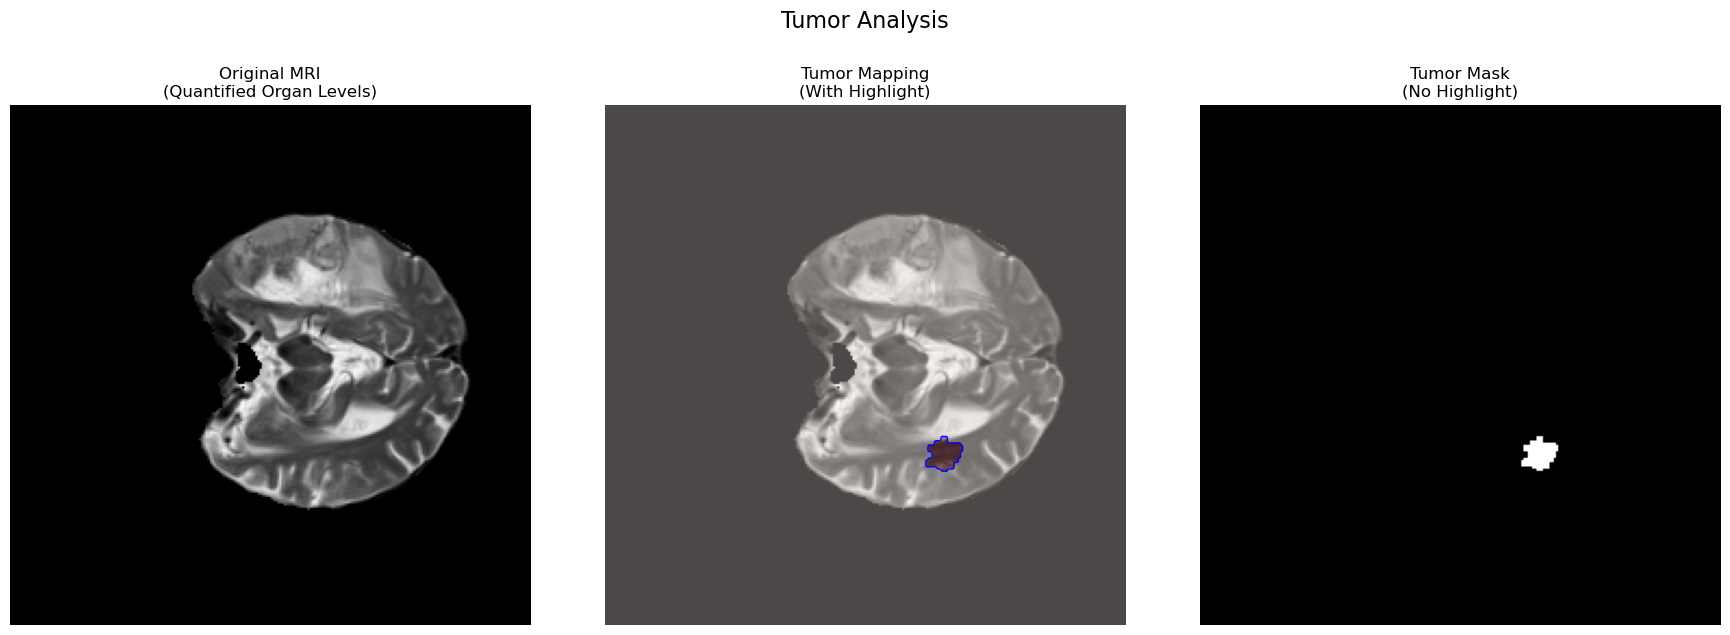

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from skimage import measure
from pathlib import Path

def visualize_tumor_maps(original_path, synthetic_path, slice_idx=None):
    """Visualize Original MRI, Tumor Overlay, and Clean Tumor Mask"""
    try:
        # Load data
        with h5py.File(original_path, 'r') as f:
            original = f['image'][:][-1] if f['image'][:].ndim == 4 else f['image'][:]
        
        with h5py.File(synthetic_path, 'r') as f:
            synthetic_mask = f['mask'][0] if 'mask' in f else None

        # Select slice
        if slice_idx is None:
            slice_idx = original.shape[-1] // 2
        elif slice_idx >= original.shape[-1]:
            slice_idx = original.shape[-1] - 1

        # Create figure
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Tumor Analysis', fontsize=16, y=1.05)

        # 1. Original MRI
        ax1.imshow(original[:, :, slice_idx], cmap='gray')
        ax1.set_title('Original MRI\n(Quantified Organ Levels)')
        ax1.axis('off')

        # 2. Tumor Overlay (with red)
        ax2.imshow(original[:, :, slice_idx], cmap='gray')
        if synthetic_mask is not None:
            ax2.imshow(synthetic_mask[:, :, slice_idx], cmap='Reds', alpha=0.3)
            contours = measure.find_contours(synthetic_mask[:, :, slice_idx], 0.5)
            for contour in contours:
                ax2.plot(contour[:, 1], contour[:, 0], 'blue', linewidth=1)
        ax2.set_title('Tumor Mapping\n(With Highlight)')
        ax2.axis('off')

        # 3. Clean Tumor Mask (no red)
        if synthetic_mask is not None:
            ax3.imshow(synthetic_mask[:, :, slice_idx], cmap='gray')
            ax3.set_title('Tumor Mask\n(No Highlight)')
        else:
            ax3.axis('off')
        ax3.axis('off')

        plt.tight_layout()
        plt.savefig('tumor_maps.png', bbox_inches='tight', dpi=300)
        plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__": #example
    original_file = "/Users/jiexili/Downloads/archive 2/BraTS2020_training_data/content/data/volume_100_slice_62.h5"
    synthetic_file = "/Users/jiexili/Downloads/synthetic_tumors/synthetic_volume_100_slice_62.h5"
    
    if Path(original_file).exists() and Path(synthetic_file).exists():
        visualize_tumor_maps(original_file, synthetic_file, slice_idx=30)
    else:
        print("Error: Files not found")

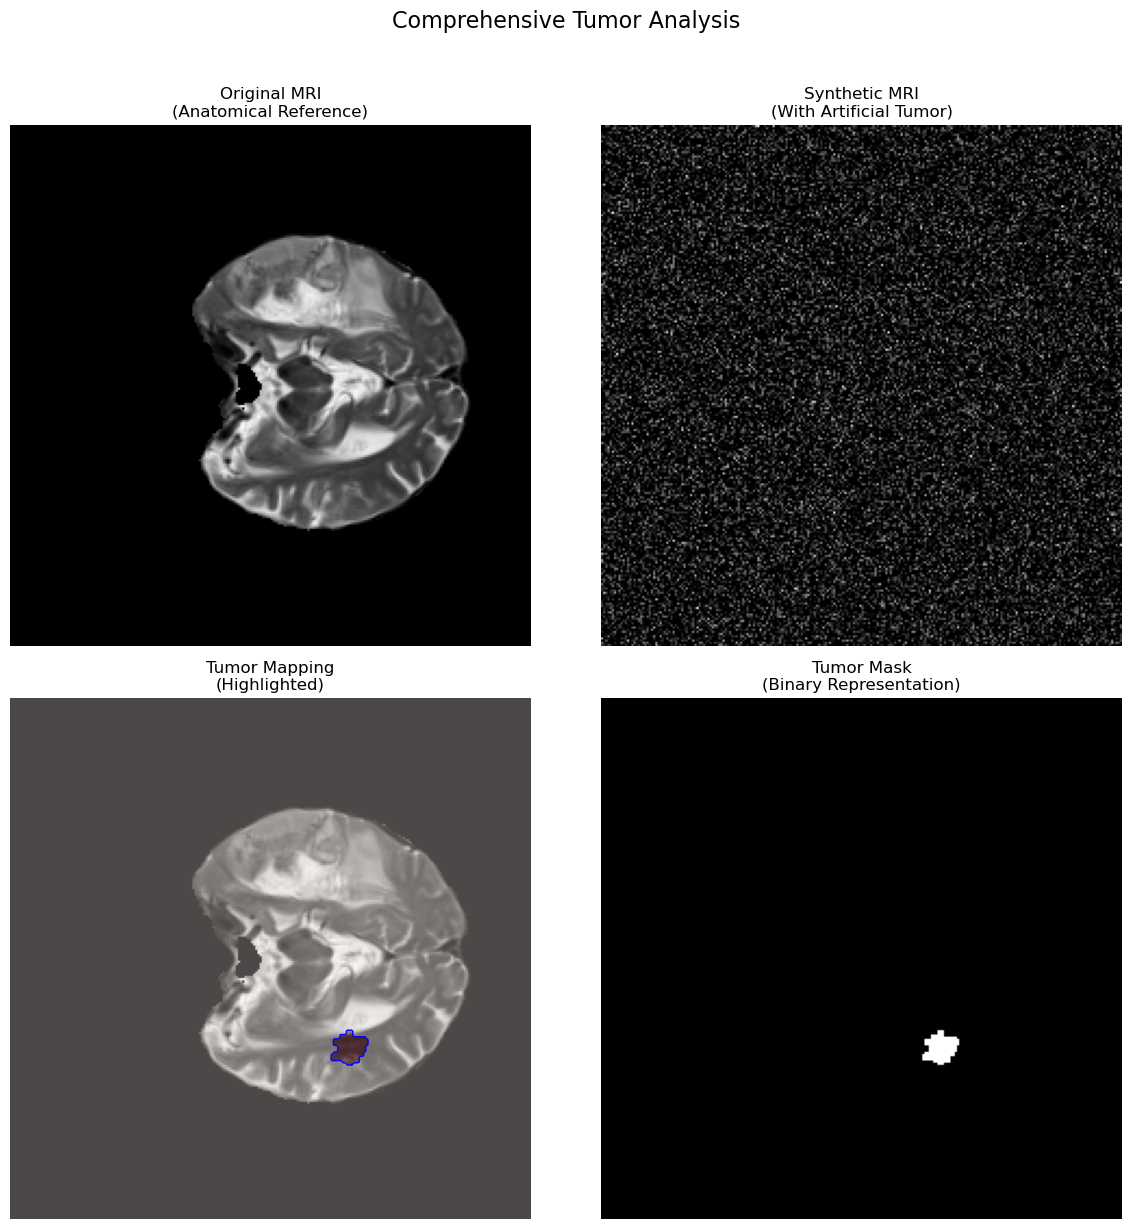

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from skimage import measure
from pathlib import Path

def visualize_all_views(original_path, synthetic_path, slice_idx=None): # Visualize all four views: Original, Synthetic, Tumor Overlay, and Clean Mask
    try:
        # Load data
        with h5py.File(original_path, 'r') as f:
            original = f['image'][:][-1] if f['image'][:].ndim == 4 else f['image'][:]
        
        with h5py.File(synthetic_path, 'r') as f:
            synthetic = f['image'][:][-1] if f['image'][:].ndim == 4 else f['image'][:]
            synthetic_mask = f['mask'][0] if 'mask' in f else None

        # Select slice
        if slice_idx is None:
            slice_idx = original.shape[-1] // 2
        elif slice_idx >= original.shape[-1]:
            slice_idx = original.shape[-1] - 1

        # Create figure
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
        fig.suptitle('Comprehensive Tumor Analysis', fontsize=16, y=1.02)

        # 1. Original MRI
        ax1.imshow(original[:, :, slice_idx], cmap='gray')
        ax1.set_title('Original MRI\n(Anatomical Reference)')
        ax1.axis('off')

        # 2. Synthetic MRI
        ax2.imshow(synthetic[:, :, slice_idx], cmap='gray')
        ax2.set_title('Synthetic MRI\n(With Artificial Tumor)')
        ax2.axis('off')

        # 3. Tumor Overlay (with red highlight)
        ax3.imshow(original[:, :, slice_idx], cmap='gray')
        if synthetic_mask is not None:
            ax3.imshow(synthetic_mask[:, :, slice_idx], cmap='Reds', alpha=0.3)
            contours = measure.find_contours(synthetic_mask[:, :, slice_idx], 0.5)
            for contour in contours:
                ax3.plot(contour[:, 1], contour[:, 0], 'blue', linewidth=1)
        ax3.set_title('Tumor Mapping\n(Highlighted)')
        ax3.axis('off')

        # 4. Clean Tumor Mask
        if synthetic_mask is not None:
            ax4.imshow(synthetic_mask[:, :, slice_idx], cmap='gray')
            ax4.set_title('Tumor Mask\n(Binary Representation)')
        else:
            ax4.axis('off')
        ax4.axis('off')

        plt.tight_layout()
        plt.savefig('comprehensive_tumor_views.png', bbox_inches='tight', dpi=300)
        plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__": #example
    original_file = "/Users/jiexili/Downloads/archive 2/BraTS2020_training_data/content/data/volume_100_slice_62.h5"
    synthetic_file = "/Users/jiexili/Downloads/synthetic_tumors/synthetic_volume_100_slice_62.h5"
    
    if Path(original_file).exists() and Path(synthetic_file).exists():
        visualize_all_views(original_file, synthetic_file, slice_idx=30)
    else:
        print("Error: Input files not found. Please check paths.")

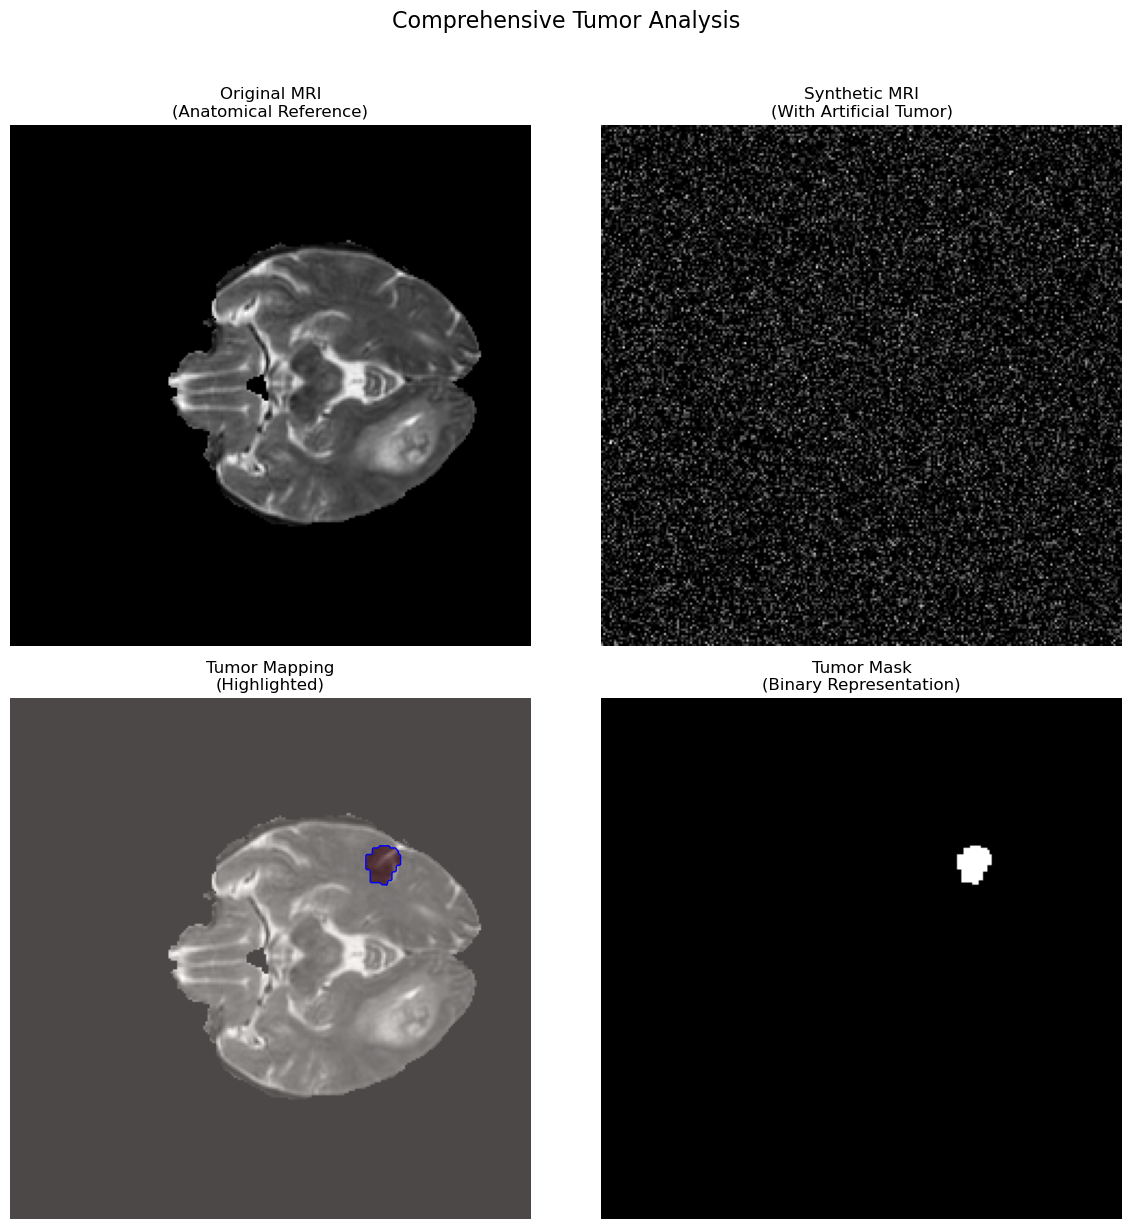

In [30]:
if __name__ == "__main__": #example
    original_file = "/Users/jiexili/Downloads/archive 2/BraTS2020_training_data/content/data/volume_216_slice_68.h5"
    synthetic_file = "/Users/jiexili/Downloads/synthetic_tumors/synthetic_volume_216_slice_68.h5"
    
    if Path(original_file).exists() and Path(synthetic_file).exists():
        visualize_all_views(original_file, synthetic_file, slice_idx=30)
    else:
        print("Error: Input files not found. Please check paths.")

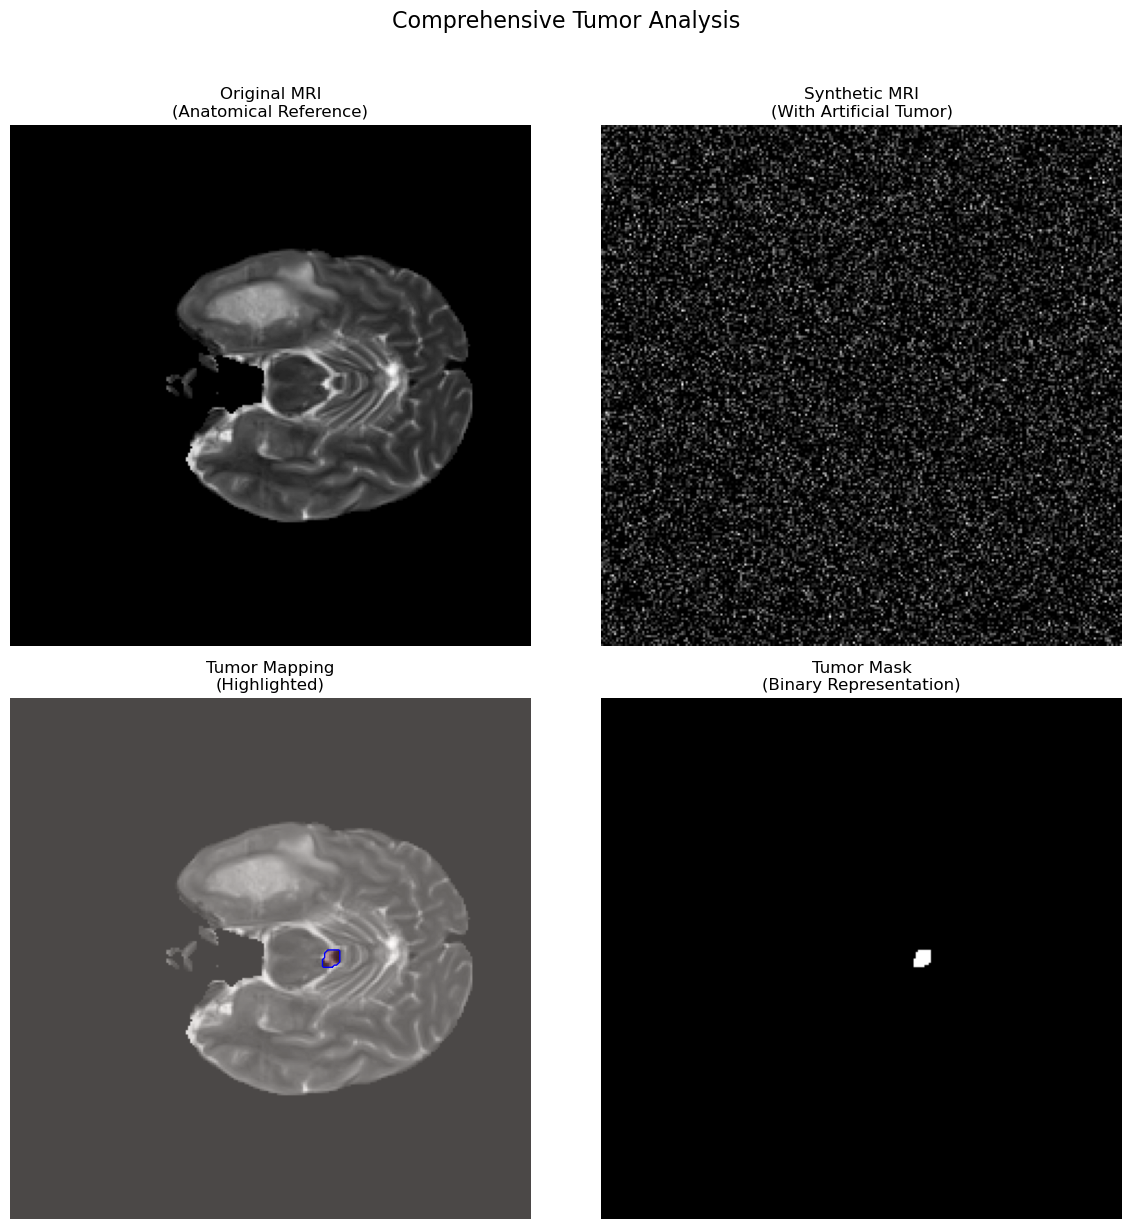

In [31]:
if __name__ == "__main__": #example
    original_file = "/Users/jiexili/Downloads/archive 2/BraTS2020_training_data/content/data/volume_116_slice_48.h5"
    synthetic_file = "/Users/jiexili/Downloads/synthetic_tumors/synthetic_volume_116_slice_48.h5"
    
    if Path(original_file).exists() and Path(synthetic_file).exists():
        visualize_all_views(original_file, synthetic_file, slice_idx=30)
    else:
        print("Error: Input files not found. Please check paths.")

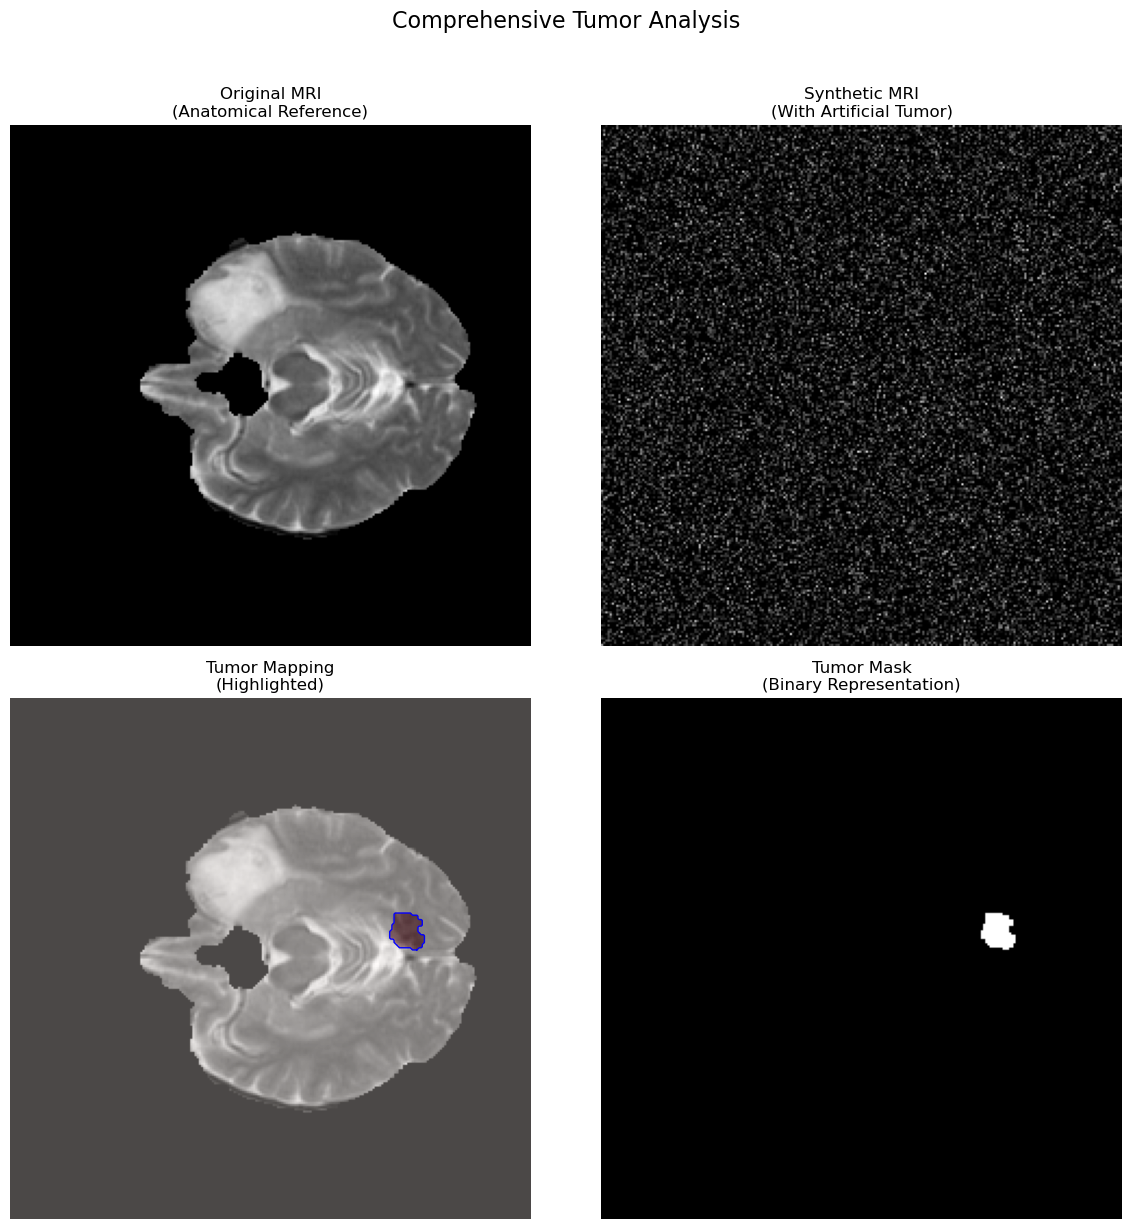

In [29]:
if __name__ == "__main__": #example
    original_file = "/Users/jiexili/Downloads/archive 2/BraTS2020_training_data/content/data/volume_200_slice_52.h5"
    synthetic_file = "/Users/jiexili/Downloads/synthetic_tumors/synthetic_volume_200_slice_52.h5"
    
    if Path(original_file).exists() and Path(synthetic_file).exists():
        visualize_all_views(original_file, synthetic_file, slice_idx=30)
    else:
        print("Error: Input files not found. Please check paths.")

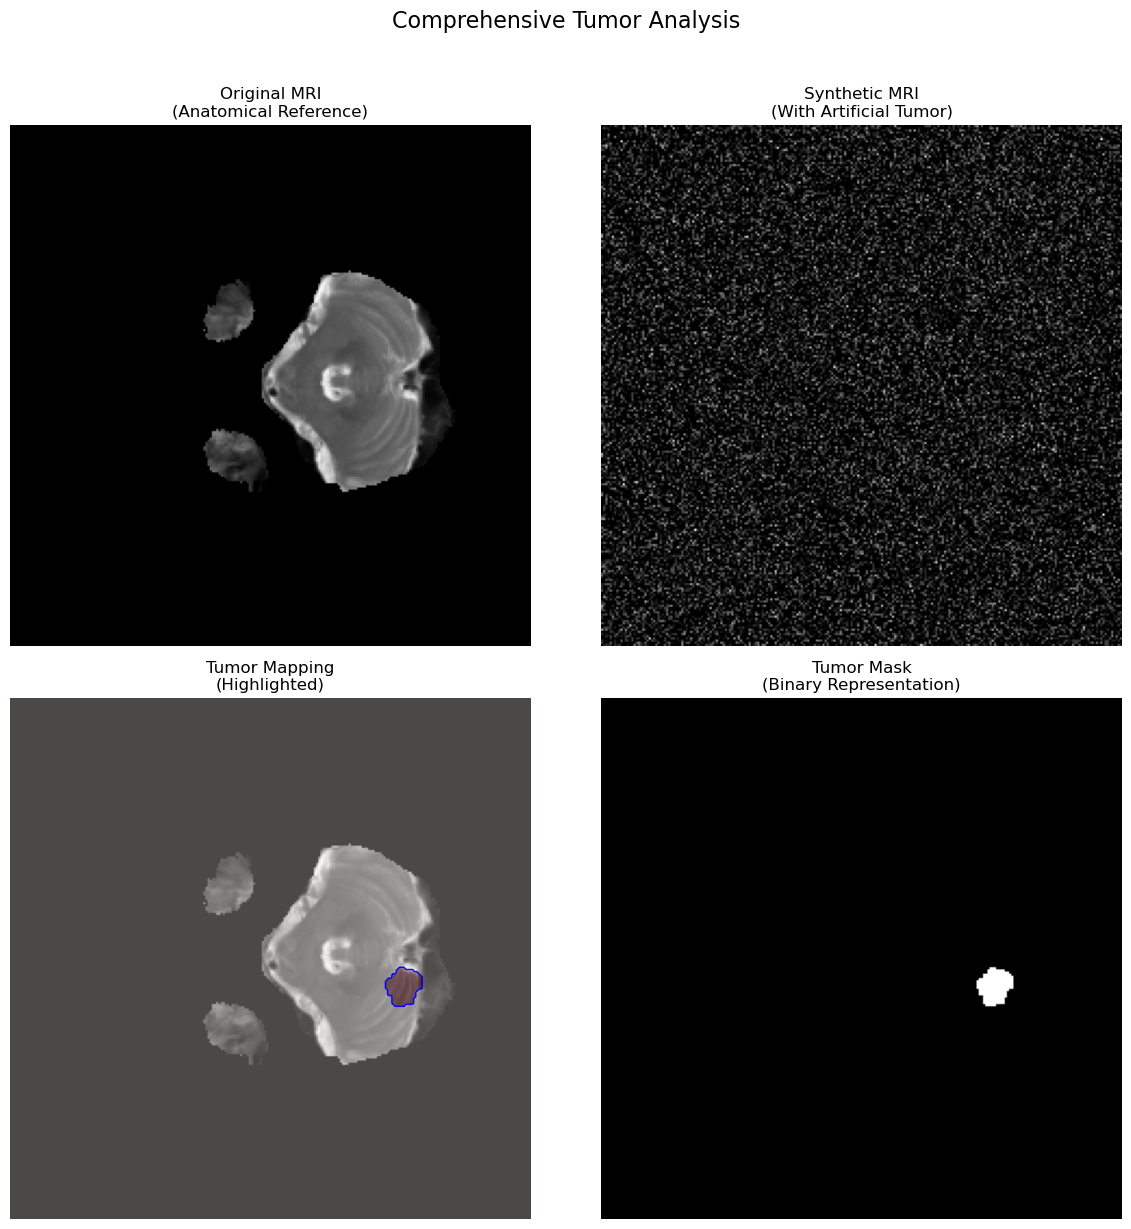

In [32]:
if __name__ == "__main__": #example
    original_file = "/Users/jiexili/Downloads/archive 2/BraTS2020_training_data/content/data/volume_316_slice_28.h5"
    synthetic_file = "/Users/jiexili/Downloads/synthetic_tumors/synthetic_volume_316_slice_28.h5"
    
    if Path(original_file).exists() and Path(synthetic_file).exists():
        visualize_all_views(original_file, synthetic_file, slice_idx=30)
    else:
        print("Error: Input files not found. Please check paths.")